In [334]:
# Import modules
import numpy as np
import pandas as pd
import chemparse

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [335]:
# Import data
df = pd.read_csv("lithium-ion batteries.csv")

In [336]:
df.head()

,Materials Id,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,mp-849394,Li2MnSiO4,Pc,-2.699,0.006,3.462,16,2.993,178.513,True,monoclinic
1,mp-783909,Li2MnSiO4,P21/c,-2.696,0.008,2.879,32,2.926,365.272,True,monoclinic
2,mp-761311,Li4MnSi2O7,Cc,-2.775,0.012,3.653,28,2.761,301.775,True,monoclinic
3,mp-761598,Li4Mn2Si3O10,C2/c,-2.783,0.013,3.015,38,2.908,436.183,True,monoclinic
4,mp-767709,Li2Mn3Si3O10,C2/c,-2.747,0.016,2.578,36,3.334,421.286,True,monoclinic


In [337]:
len(df)

339

In [339]:
# We look at the str-type columns and how their unique values look like in order to get an idea of where to use dummies and not.
for col in ["Formula", "Spacegroup", "Crystal System"]:
    print(f"Column: {col}")
    print(f"Values: {df[col].unique()}\n")
    print("------------------------------------------------------")

Column: Formula
Values: ['Li2MnSiO4' 'Li4MnSi2O7' 'Li4Mn2Si3O10' 'Li2Mn3Si3O10' 'LiMnSiO4'
 'LiMn(SiO3)2' 'Li2Mn(SiO3)2' 'Li2Mn2Si2O7' 'Li10Mn(SiO5)2' 'Li3MnSi2O7'
 'Li5Mn(SiO4)2' 'Li2Mn(Si2O5)2' 'Li2Mn2Si3O10' 'Li2Mn2(SiO3)3'
 'Li2MnSi3O8' 'Li3Mn2(SiO4)2' 'Li4Mn(SiO3)3' 'LiMn2Si2O7' 'Li3Mn3SiO8'
 'Li2MnSi4O11' 'Li5Mn(SiO3)4' 'Li7Mn3(SiO6)2' 'LiFe(SiO3)2' 'Li2FeSiO4'
 'LiFe(Si2O5)2' 'Li4FeSi2O7' 'LiFeSiO4' 'Li5Fe(SiO4)2' 'Li4Fe2Si3O10'
 'Li2Fe3Si3O10' 'Li3Fe2(SiO4)2' 'LiFeSi3O8' 'Li2Fe2Si2O7' 'LiFe2Si2O7'
 'Li2Fe(SiO3)2' 'Li10Fe(SiO5)2' 'Li9Fe5(SiO8)2' 'Li2Fe(Si2O5)2'
 'Li2Fe2Si8O19' 'Li2FeSi3O8' 'Li2Fe2(SiO3)3' 'Li7Fe3(SiO6)2'
 'Li4Fe(SiO3)3' 'Li3Fe3SiO8' 'Li2Fe(Si2O5)3' 'Li2FeSi4O11' 'LiFe2(SiO4)2'
 'Li2CoSiO4' 'Li4Co2Si3O10' 'Li3Co2(SiO4)2' 'Li2Co2Si2O7' 'Li10Co(SiO5)2'
 'LiCo(SiO3)2' 'Li2Co(SiO3)2' 'LiCoSiO4' 'Li2Co2(SiO3)3' 'Li2Co(Si2O5)2'
 'Li2CoSi3O8' 'Li3Co2Si3O10' 'Li4Co(SiO3)3' 'Li5Co2(SiO5)2'
 'Li3Mn(Si2O5)3' 'Li2Mn2(Si2O5)3' 'Li4Mn2Si4O13' 'Li2Mn3(SiO3)4'
 'Li3MnSiO5' 'Li2M

In [273]:
# Let's prase the chemical formulas with chemparse: https://pypi.org/project/chemparse/

# Parse the forumlas into a dictionary format
chem_df = df.Formula.apply(chemparse.parse_formula)

# Convert the dictionary into a dataframe and fill NaN's with zero's
chem_df = pd.json_normalize(chem_df)
chem_df = chem_df.fillna(0)

# Join back into the original df
df = df.join(chem_df)

In [274]:
# Let's not forget to drop the original formula column
df = df.drop(columns=["Formula"])

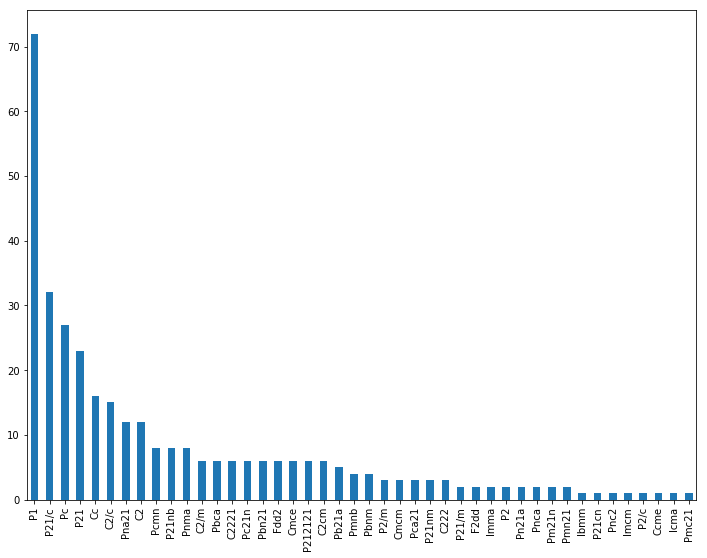

In [275]:
# Let's look at Spacegroup
plt.figure(figsize=(12,9))

spaceg_data = df.Spacegroup.value_counts()

spaceg_data.plot(kind="bar")
plt.show()


In [276]:
# We turn the spacegroups into categorical numerical variables
df.Spacegroup = df.Spacegroup.rank(method="dense").astype(int)

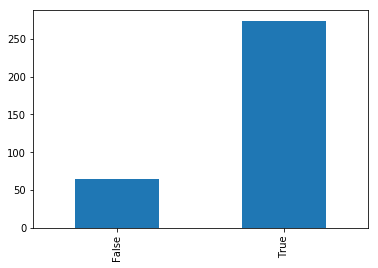

In [277]:
# Now bandstructure
df["Has Bandstructure"].value_counts().plot(kind="bar")

In [278]:
# Mapping the values to 1 for true, 0 for false
df["Has Bandstructure"] = df["Has Bandstructure"].map({True:1, False:0})

In [279]:
# Final processing: get dummies for Crystal System and drop the ID-column
df = df.drop(columns=["Materials Id"])

In [280]:
# Categorical variables for Crystal System as well
df["Crystal System"] = df["Crystal System"].rank(method="dense").astype(int)

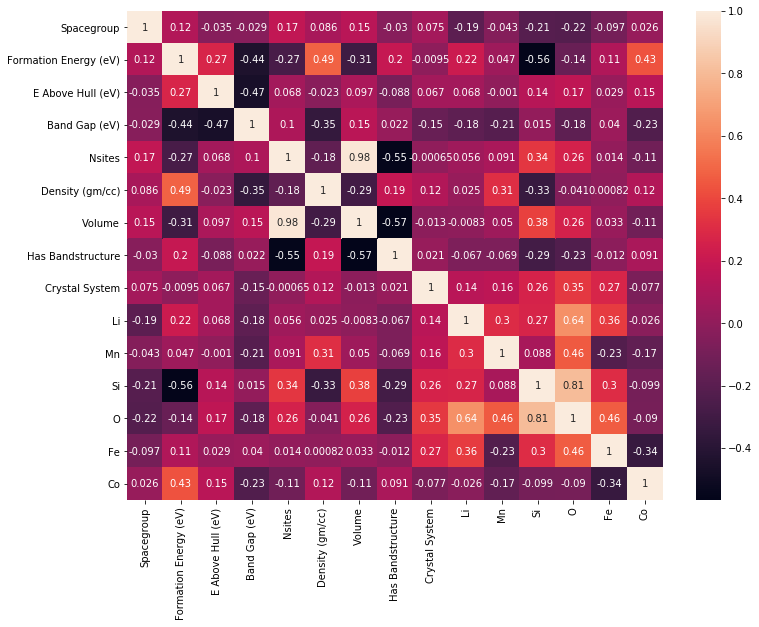

In [321]:
# Let's look at a heatmap for the features
correlations = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlations, annot=True)

In [281]:
# Let's split up the dataframe into feature data and labels
y = df["Crystal System"]
X = df.drop(columns=["Crystal System"])

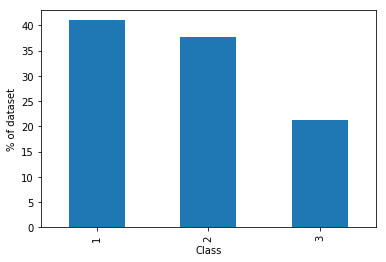

In [282]:
# Quick look of distribution of Crystal System values
yvals = y.value_counts() / len(y) * 100
yvals.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("% of dataset")
plt.show()

In [283]:
# A baseline model predicting only 1's would result in about 40% accuracy. 

In [323]:
# Starting with a decision tree classifier, using 80% of data for training and the rest for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


1.0

In [330]:
import xgboost

# Now using an xgboost classifier
clf = xgboost.XGBClassifier(verbosity=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

In [286]:
# Both the decisiontree-model and xgboost scored 100%. Now, the dataset is pretty small, only a bit over 300 observations. Let's do a Kfold of the dataset with Xgboost and see how the results vary across different splits of the data

In [305]:
# Let's do 10 splits of the data

kfold = KFold(n_splits = 10)

n = 1

clf_xg = xgboost.XGBClassifier(verbosity=0)
clf_dt = DecisionTreeClassifier()

# Convert the data to np-arrays to enable indexing in the loop
X_data = np.array(X)
y_data = np.array(y)

for train, val in kfold.split(X_data, y_data):
    
    # Xgboost
    clf_xg.fit(X_data[train], y_data[train])
    acc = clf_xg.score(X_data[val], y_data[val])
    print(f"XG: Fold {n} ACC: {acc}")

    # Decision tree
    clf_dt.fit(X_data[train], y_data[train])
    acc = clf_dt.score(X_data[val], y_data[val])
    print(f"Dtree: Fold {n} ACC: {round(acc, 2)}")

    print("---------------------")

    n += 1
    

XG: Fold 1 ACC: 1.0
Dtree: Fold 1 ACC: 1.0
---------------------
XG: Fold 2 ACC: 1.0
Dtree: Fold 2 ACC: 0.91
---------------------
XG: Fold 3 ACC: 1.0
Dtree: Fold 3 ACC: 0.85
---------------------
XG: Fold 4 ACC: 1.0
Dtree: Fold 4 ACC: 0.94
---------------------
XG: Fold 5 ACC: 1.0
Dtree: Fold 5 ACC: 0.97
---------------------
XG: Fold 6 ACC: 1.0
Dtree: Fold 6 ACC: 1.0
---------------------
XG: Fold 7 ACC: 1.0
Dtree: Fold 7 ACC: 0.97
---------------------
XG: Fold 8 ACC: 1.0
Dtree: Fold 8 ACC: 0.97
---------------------
XG: Fold 9 ACC: 1.0
Dtree: Fold 9 ACC: 1.0
---------------------
XG: Fold 10 ACC: 1.0
Dtree: Fold 10 ACC: 1.0
---------------------


In [341]:
# While xgboost performed constantly at 100%, the decision tree classifier har a larger variance in it's results. Varying from 85% to 100% depending on the fold of the data.
